In [16]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [17]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()
chars = ["."] + sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
block_size = 3
vocab_size = len(itos)
embedding_size = 10
hidden_size = 200

In [18]:
def build_dataset(words, block_size):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(y)


def split_dataset(words):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))
    train = words[:n1]
    dev = words[n1:n2]
    test = words[n2:]
    X_train, y_train = build_dataset(train, block_size)
    X_dev, y_dev = build_dataset(dev, block_size)
    X_test, y_test = build_dataset(test, block_size)
    return X_train, y_train, X_dev, y_dev, X_test, y_test


X_train, y_train, X_dev, y_dev, X_test, y_test = split_dataset(words)

In [19]:
gain = 5 / 3
fan_in = block_size * embedding_size
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = (
    torch.randn((block_size * embedding_size, hidden_size), generator=g)
    * gain
    / (fan_in**0.5)
)
# b1 = torch.randn(hidden_size, generator=g) * 0.01
W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))
bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))
parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [20]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[ix], y_train[ix]
    emb = C[Xb]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"{i} / {max_steps}, loss: {loss.item()}")
    lossi.append(loss.log10().item())

0 / 200000, loss: 3.2906885147094727


KeyboardInterrupt: 

(array([449., 230., 167., 137., 144., 133., 101., 110.,  92.,  99., 106.,
         96.,  93.,  93.,  72., 114., 114.,  91.,  75.,  87., 113., 112.,
        161., 131., 113., 129., 129.,  82.,  91.,  71., 115., 109., 100.,
         76.,  94., 100., 111.,  74., 117., 101., 121.,  99.,  99., 110.,
        104., 143., 148., 165., 220., 459.]),
 array([-9.99957621e-01, -9.59958558e-01, -9.19959495e-01, -8.79960432e-01,
        -8.39961369e-01, -7.99962306e-01, -7.59963243e-01, -7.19964180e-01,
        -6.79965117e-01, -6.39966054e-01, -5.99966991e-01, -5.59967928e-01,
        -5.19968865e-01, -4.79969802e-01, -4.39970739e-01, -3.99971676e-01,
        -3.59972613e-01, -3.19973550e-01, -2.79974487e-01, -2.39975424e-01,
        -1.99976361e-01, -1.59977298e-01, -1.19978235e-01, -7.99791718e-02,
        -3.99801087e-02,  1.89542770e-05,  4.00180173e-02,  8.00170803e-02,
         1.20016143e-01,  1.60015206e-01,  2.00014269e-01,  2.40013332e-01,
         2.80012395e-01,  3.20011458e-01,  3.60010

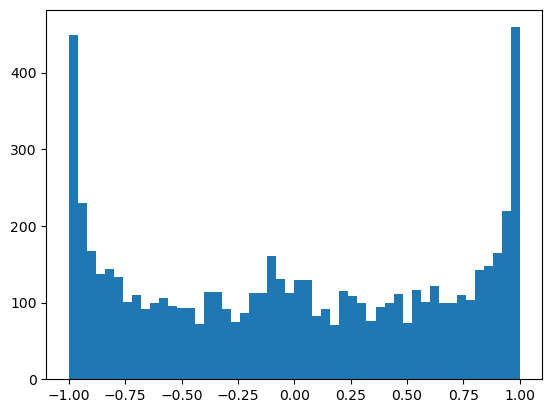

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50)

(array([  2.,   2.,   0.,   2.,   3.,  10.,  10.,  19.,  28.,  39.,  38.,
         52.,  84., 110., 142., 148., 181., 252., 298., 355., 416., 559.,
        753., 540., 452., 422., 284., 268., 185., 170., 134., 114.,  80.,
         58.,  40.,  40.,  40.,  25.,  16.,   7.,   2.,   7.,   2.,   1.,
          3.,   1.,   1.,   2.,   2.,   1.]),
 array([-5.38103628, -5.14333303, -4.90562979, -4.66792654, -4.43022329,
        -4.19252005, -3.9548168 , -3.71711355, -3.47941031, -3.24170706,
        -3.00400381, -2.76630056, -2.52859732, -2.29089407, -2.05319082,
        -1.81548758, -1.57778433, -1.34008108, -1.10237783, -0.86467459,
        -0.62697134, -0.38926809, -0.15156485,  0.0861384 ,  0.32384165,
         0.5615449 ,  0.79924814,  1.03695139,  1.27465464,  1.51235788,
         1.75006113,  1.98776438,  2.22546762,  2.46317087,  2.70087412,
         2.93857737,  3.17628061,  3.41398386,  3.65168711,  3.88939035,
         4.1270936 ,  4.36479685,  4.6025001 ,  4.84020334,  5.07790659,
 

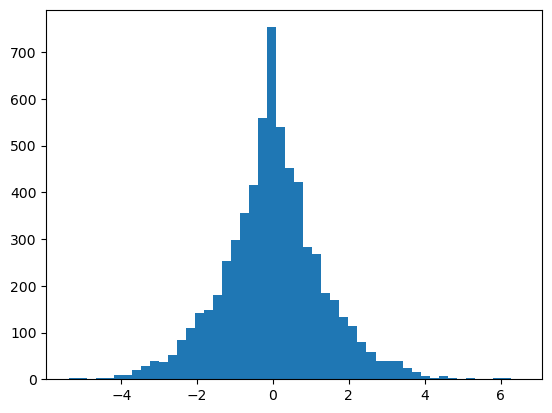

In [ ]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

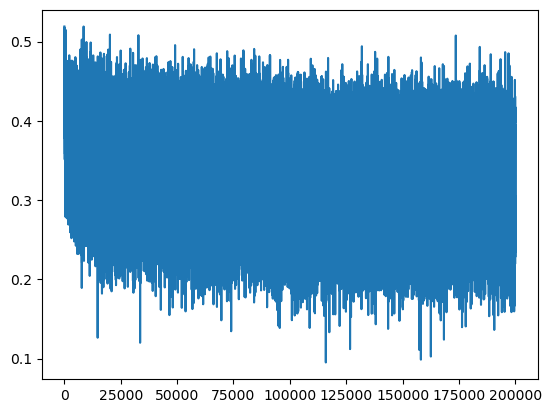

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        "train": (X_train, y_train),
        "val": (X_dev, y_dev),
        "test": (X_test, y_test),
    }[split]
    emb = C[X]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0692358016967773
val 2.1137099266052246


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

prigh.
qliersbellessatonllyannophtishaqliahrydajoelleimarcynce.
lishbahryrah.
erra.
erilmirah.
thanindif.
evallyxessdorssadna.
jahkhirzhirzhadryliahlyncksholuwatder.
quaraidershquennvamillynebtulck.
jourdilandwrorgh.
gabrilynathmariahmillyuthyna.
evallivio.
damstiamrishold.
pabbryn.
allamder.
qliahrah.
talandrwgold.
phingt.
pynsleigh.
jpragdnx.


In [ ]:
# SUMMARY + PYTORCHIFYING -----------

In [25]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = (
            torch.randn(fan_in, fan_out, generator=g) * gain / (fan_in**0.5)
        )
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a runnning 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            self.running_mean = (
                1 - self.momentum
            ) * self.running_mean + self.momentum * xmean
            self.running_var = (
                1 - self.momentum
            ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self):
        return []


vocab_size = len(itos)
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size, bias=False),
    BatchNorm1d(vocab_size),
]
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

25124
